# Initialization

## Importing libs and setting plot style

In [4]:
import itertools
import multiprocessing as mp
import os
import random
import threading
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from atpbar import atpbar, flush
from matplotlib import rc

In [5]:
# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc("text", usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid",
    {
        "axes.edgecolor": "black",
        "axes.grid": True,
        "axes.axisbelow": True,
        "axes.labelcolor": ".15",
        "grid.color": "0.9",
        "grid.linestyle": "-",
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.bottom": True,
        "xtick.top": True,
        "ytick.left": True,
        "ytick.right": True,
        "font.family": ["sans-serif"],
        "font.sans-serif": ["Liberation Sans", "Bitstream Vera Sans", "sans-serif"],
    },
)

## Global variables

In [36]:
# folder with stored data
data_folder = "../../data"

# spinfoam model
model = "vertex"

# MH parameters
spins = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
sigmas = [0.8 for i in range(0, 12)]
lengths = [10**6 for i in range(0, 12)]
burnins = [0 for i in range(0, 12)] 
batch_sizes = [10**5 for i in range(0, 12)]

# set optimal number of threads
optimal_number_of_threads = int(mp.cpu_count())
print(f"optimal number of threads: {optimal_number_of_threads}")

optimal number of threads: 12


# Angles

## Computation

In [37]:
# takes an intertwiner and returns the corresponding angle eigenvalue
def from_intertwiner_to_angle(matrix_element, spin):
    return (matrix_element * (matrix_element + 1) - 2 * spin * (spin + 1)) / (
        2 * spin * (spin + 1)
    )

In [38]:
def from_draws_to_angles(
    folder_prefix,
    spin,
    angle_path,
    batch_id,
    n,
    name,
    lag_max_autocorr=8000,
    node_autocorr=1,
):

    for i in atpbar(range(n), name=name):
        time.sleep(0.0001)

    draw_path = f"{folder_prefix}/draws/draws_batch_n_{batch_id}.csv"

    # load in memory the stored draws
    df = pd.read_csv(draw_path, low_memory=False)
    df.columns = df.columns.str.replace("intertwiner ", "node ", regex=True)

    # retrieving relevant parameters
    multiplicity = df[["multiplicity"]].to_numpy().astype(int)

    # from intertwiners to angles
    df.iloc[:, :-1] = df.iloc[:, :-1].apply(from_intertwiner_to_angle, args=(spin,))

    # taking multiplicity into account
    df = df.loc[df.index.repeat(df["multiplicity"])]

    # dropping multiplicity column
    df = df.drop(
        columns=[
            "multiplicity",
        ]
    )

    ##################################
    # Computing autocorrelation (acf)
    ##################################

    acf_node = sm.tsa.acf(df[f"node {node_autocorr}"], nlags=lag_max_autocorr)
    df_final = pd.DataFrame(acf_node, columns=[f"node {node_autocorr}"])
    df_final.index.names = ["lag"]

    angle_autocorr_path_batch = (
        f"{angle_path}/autocorrelations/node_{node_autocorr}_batch_{batch_id}.csv"
    )
    df_final.to_csv(angle_autocorr_path_batch, index=True)

    #############################
    # Computing exp values (avg)
    #############################

    df_final = pd.concat([df.mean()], axis=1)
    df_final.columns = ["cosine angle avg"]

    angle_exp_values_path_batch = f"{angle_path}/exp_values/batch_{batch_id}.csv"
    df_final.to_csv(angle_exp_values_path_batch, index=True)

In [39]:
# Converts multiple draws into angles exp. values, quantum spread, correlations and autocorrelations.
# Store the result for each batch, then combines all batchs in another CSV file

def angles_compute(
    data_folder,
    spin,
    length,
    model,
    batch_size,
    sigma,
    burnin,
    number_of_threads=optimal_number_of_threads,
    node_autocorr=1,
):

    number_of_batches = int(length/batch_size)
    
    folder_prefix = f"{data_folder}/MCMC/{model}/iterations_{length}_batch_size_{batch_size}_burnin_{burnin}_sigma_{sigma}/j_{spin}"
    batch_id_collection = []
    batches_id_string = []

    for batch_id in range(1, number_of_batches + 1):
        draw_path = f"{folder_prefix}/draws/draws_batch_n_{batch_id}.csv"
        if os.path.isfile(draw_path):
            batch_id_collection.append(batch_id)
            batches_id_string.append(f"batch {batch_id}")
            
        else:
            warnings.warn("Warning: the draw %s was not found" % (draw_path))

    batches_to_assemble = len(batch_id_collection)

    if batches_to_assemble != 0:

        angle_path = f"{folder_prefix}/operators/angles"

        angle_path_exp_values = f"{angle_path}/exp_values"
        angle_path_autocorrelations = f"{angle_path}/autocorrelations"

        os.makedirs(f"{angle_path_exp_values}", exist_ok=True)
        os.makedirs(f"{angle_path_autocorrelations}", exist_ok=True)

        print(f"\nComputing exp. values and autocorrelations of {batches_to_assemble} draws batches, using {number_of_threads} threads...\n")
        print(f"\nspin = {spin}, length = {length}, sigma = {sigma}, length = {length}, burnin = {burnin}, node_autocorr = {node_autocorr}\n")

        threads = []
        for batch_id in batch_id_collection:

            name = "batch {}".format(batch_id)
            n = random.randint(number_of_threads, 10000)

            t = threading.Thread(
                target=from_draws_to_angles,
                args=(
                    folder_prefix,
                    spin,
                    angle_path,
                    batch_id,
                    n,
                    name,
                ),
            )
            threads.append(t)
            t.start()

        # wait for the threads to complete
        for t in threads:
            t.join()

        flush()

        print(f"All draws in all batches have been processed")
        print(f"\nAssembling {batches_to_assemble} batches...")

        ##########################################################
        ### Assembling autocorrelation
        ##########################################################

        DF_list = [
            pd.read_csv(
                f"{angle_path}/autocorrelations/node_{node_autocorr}_batch_{batch_id+1}.csv",
                index_col=0,
                low_memory=False,
            )
            for batch_id in range(batches_to_assemble)
        ]

        df_all_batches = pd.concat(DF_list[:]).groupby(level=0, sort=False)

        df_final = pd.concat([df_all_batches.mean()], axis=1)
        df_final.columns = [f"node {node_autocorr}"]
        df_final.to_csv(
            f"{angle_path_autocorrelations}/batches_assembled_{batches_to_assemble}.csv",
            index=True,
        )

        ##########################################################
        ### Assembling exp values and quantum spread
        ##########################################################

        DF_list = [
            pd.read_csv(
                f"{angle_path_exp_values}/batch_{batch_id+1}.csv",
                index_col=0,
                low_memory=False,
            )
            for batch_id in range(batches_to_assemble)
        ]

        df_all_batches = pd.concat(DF_list[:], axis=1, keys = batches_id_string) 
        df_all_batches.columns = df_all_batches.columns.droplevel(-1)
        df_all_batches.T
        df_all_batches.to_csv(
            f"{angle_path_exp_values}/batches_assembled_{batches_to_assemble}.csv",
            index=True,
        )

        print("Done")

    else:
        warnings.warn("I can't compute angles since there are no batches available")

In [40]:
for spin, length, batch_size, sigma, burnin in zip(
    spins, lengths, batch_sizes, sigmas, burnins
):

    angles_compute(data_folder, spin, length, model, batch_size, sigma, burnin)


Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 0.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 1.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 1.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 2.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 2.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 3.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 3.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 4.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 4.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 5.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 5.5, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done

Computing exp. values and autocorrelations of 10 draws batches, using 12 threads...


spin = 6.0, length = 1000000, sigma = 0.8, length = 1000000, burnin = 0, node_autocorr = 1



VBox()

All draws in all batches have been processed

Assembling 10 batches...
Done


## Plots

/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will 

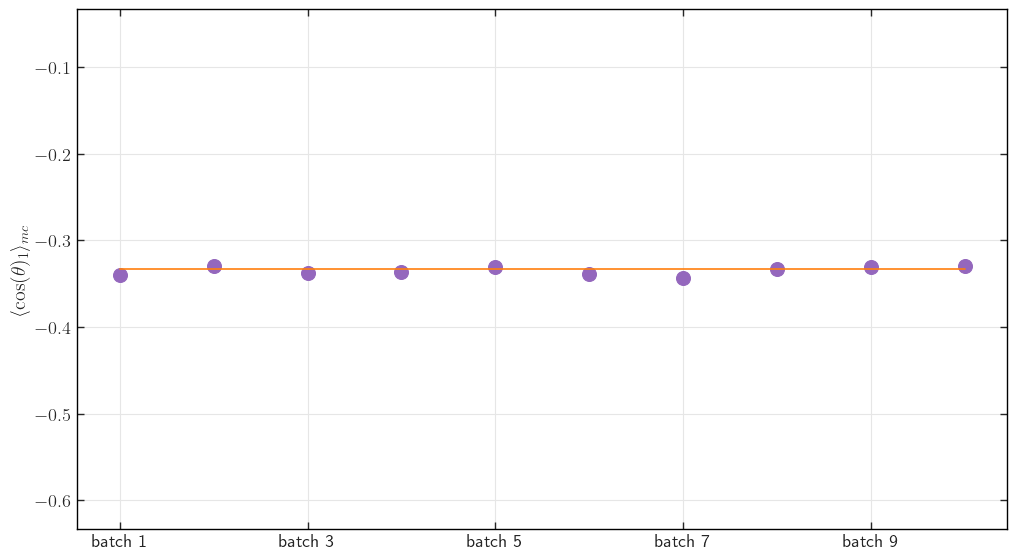

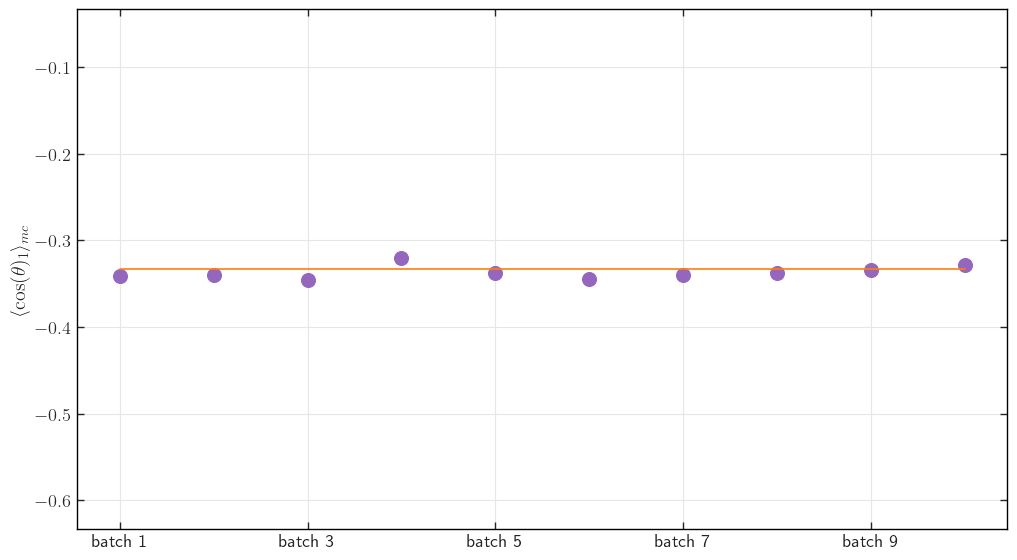

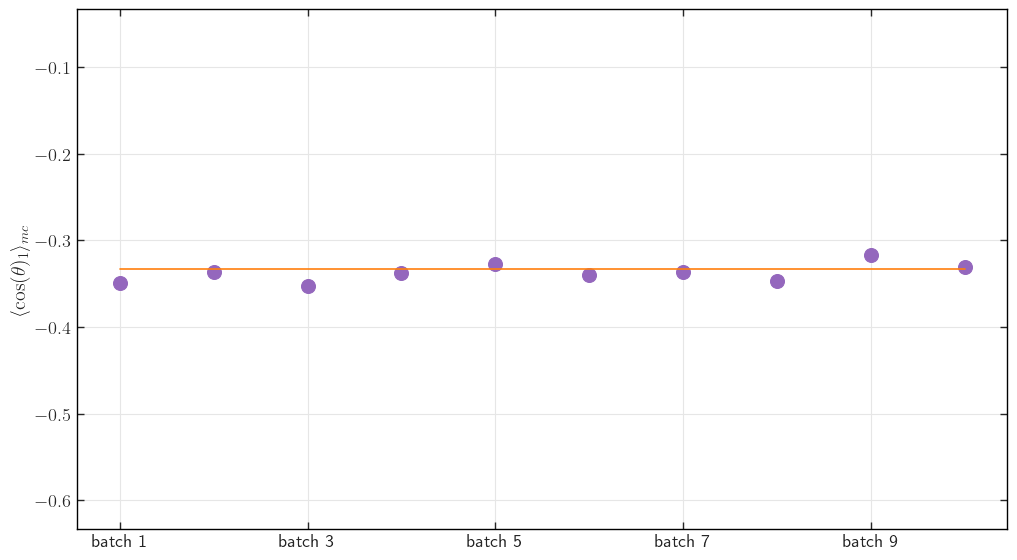

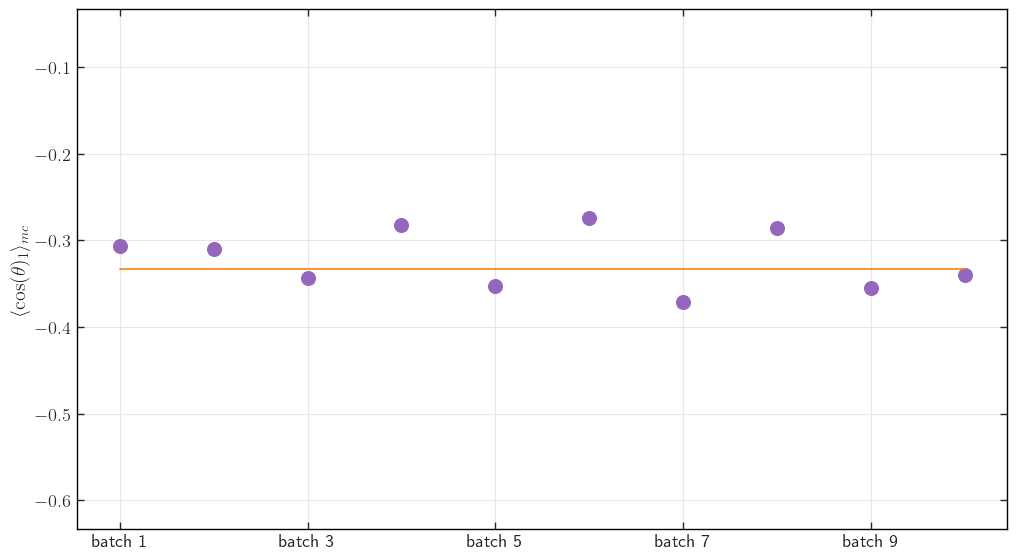

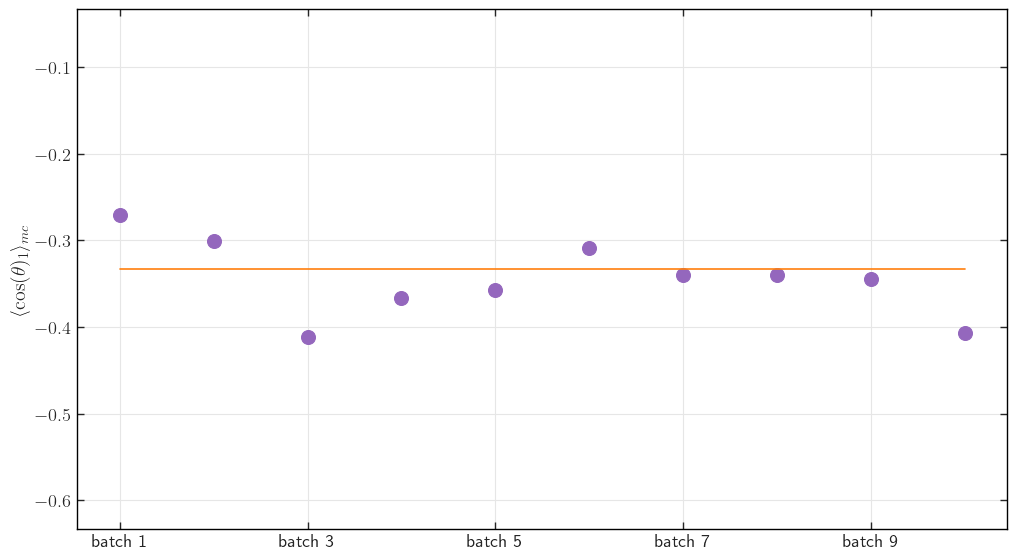

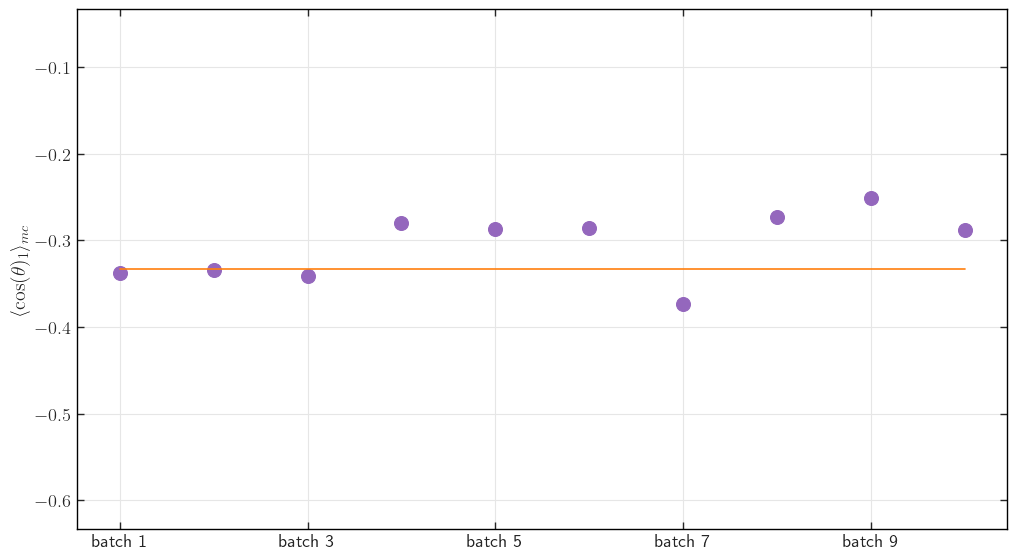

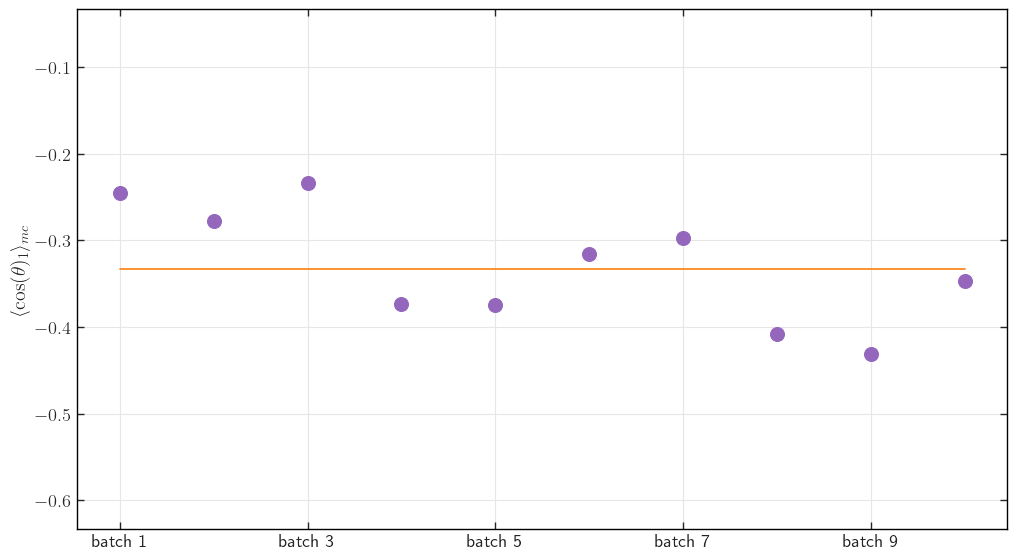

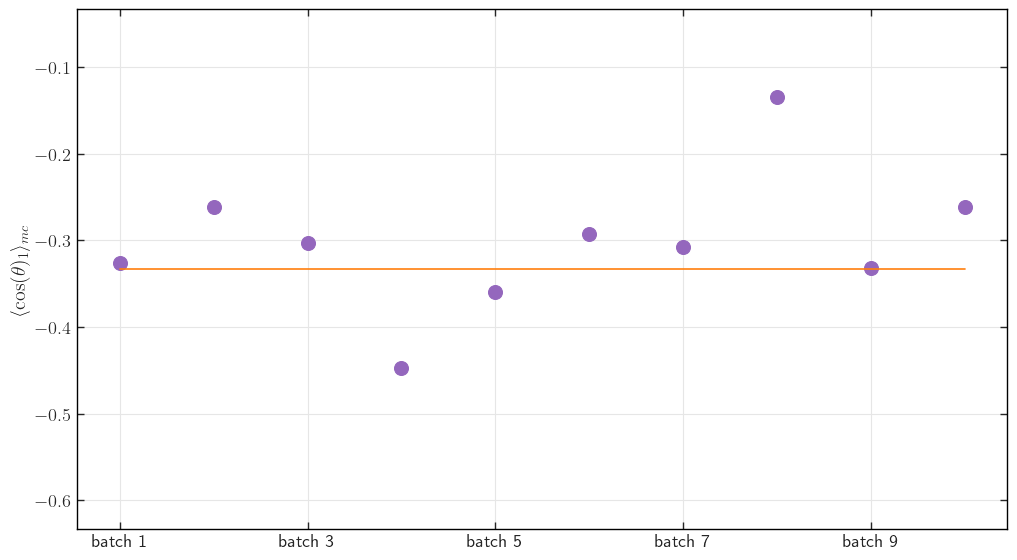

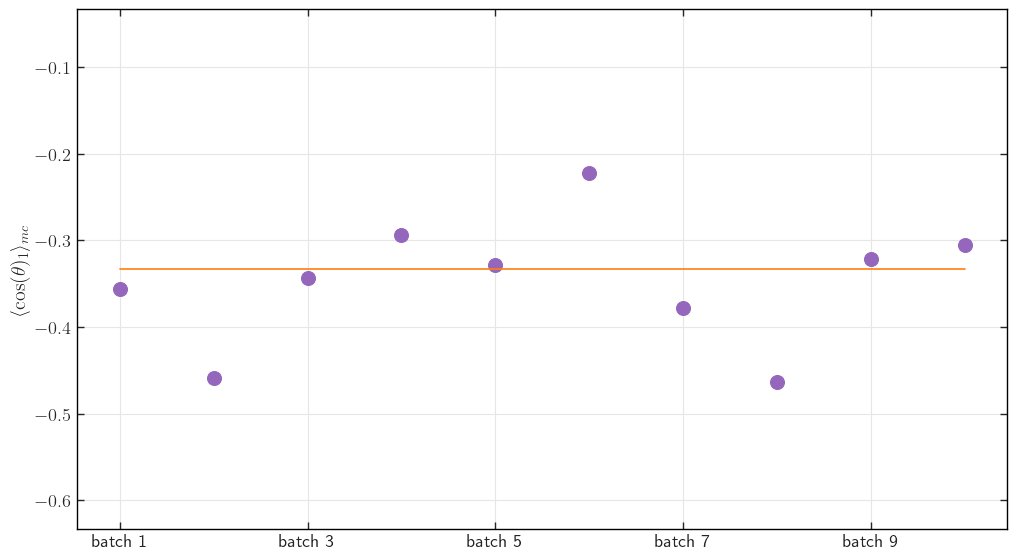

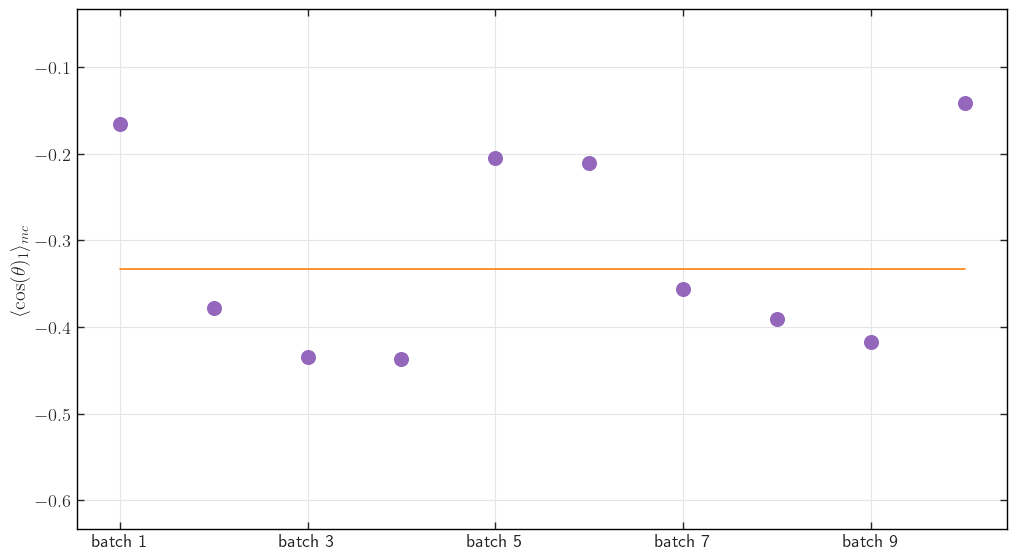

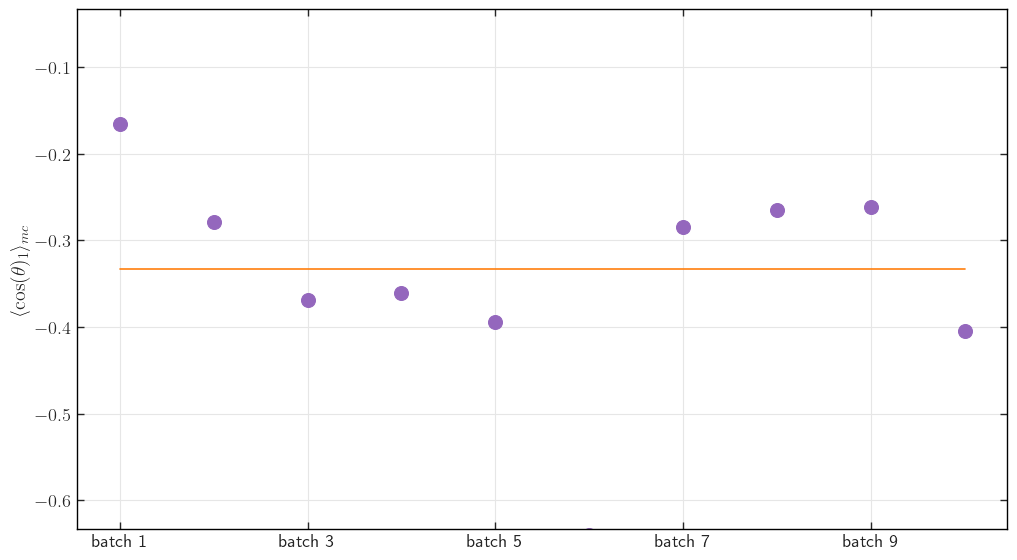

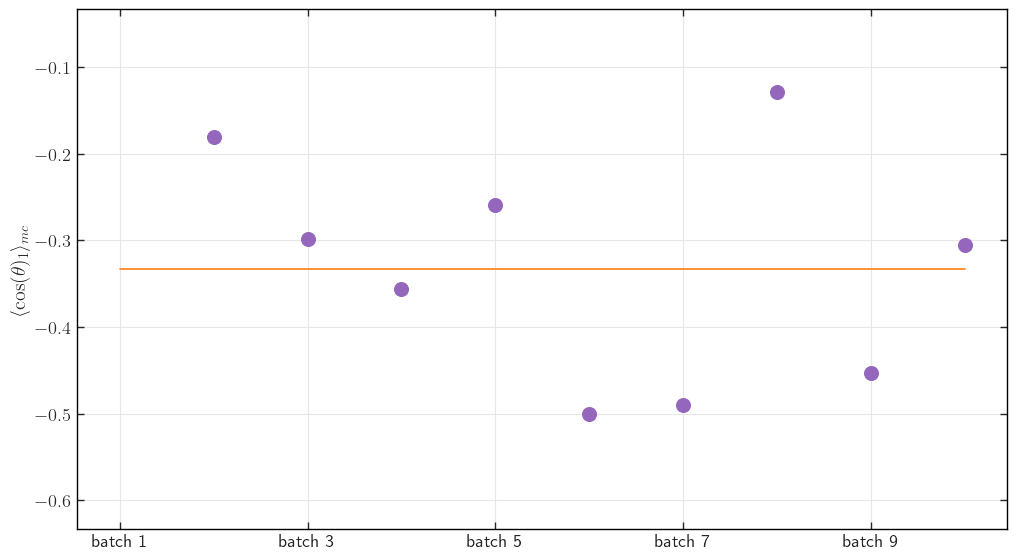

In [39]:
for spin, length, batch_size, sigma, burnin in zip(
    spins, lengths, batch_sizes, sigmas, burnins
):
    
    batches_assembled = int(length/batch_size)

    CSV_path = f"{data_folder}/MCMC/iterations_{length}_batch_size_{batch_size}_burnin_{burnin}_sigma_{sigma}/j_{spin}/operators/angles/exp_values/batches_assembled_{batches_assembled}.csv"

    df = pd.read_csv(
    f"{CSV_path}",
    low_memory=False,
    index_col=0,
    )
    
    df = df.T

    spin_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
    df["batches"] = [i for i in range(0, batches_assembled)]
    df["reg_angles"] = [-0.33333 for i in range(0, batches_assembled)]
    
    ax = df.plot(
    x="batches",
    y="node 1",
    s=100,
    kind="scatter",
    grid="false",
    color="tab:purple",
    label="computed cosine angle value",
    figsize=(12, 6.75),
    legend=False,
    )
    df.plot(
    #x="spin",
    y="reg_angles",
    ax=ax,
    kind="line",
    color="tab:orange",
    linewidth=1.2,
    label="cosine angle regular tetrahedron",
    legend=False,
    )

    delta = 0.3 
    ax.set_ylim([-0.333 - delta, -0.3333 + delta])
    plt.ylabel(r"$\langle \cos (\theta)_1 \rangle_{mc}$")
    plt.xlabel(" ")

    # save the plot
    plot_path =  f"./plots/MCMC/iterations_{length}_batch_size_{batch_size}_burnin_{burnin}_sigma_{sigma}"
    os.makedirs(plot_path, exist_ok=True)
    
    printfile = f"{plot_path}/j_{spin}_batches_assembled_{batches_assembled}"
    plt.savefig(printfile + ".svg")
    # plt.savefig(printfile+'.png',dpi=300)

In [40]:
##########################################################
### Assembling autocorrelation
##########################################################
        
node_autocorr = 1        

df_autocorr_list = []

for spin, length, batch_size, sigma, burnin in zip(spins, lengths, batch_sizes, sigmas, burnins):     
    
    folder_prefix = f"{data_folder}/MCMC/iterations_{length}_batch_size_{batch_size}_burnin_{burnin}_sigma_{sigma}/j_{spin}"
    
    angle_path = f"{folder_prefix}/operators/angles"
    angle_path_autocorrelations = f"{angle_path}/autocorrelations"
        
    df = pd.read_csv(
       f"{angle_path_autocorrelations}/batches_assembled_{batches_assembled}.csv",
       low_memory=False,
       index_col=0,
       )

    df.rename(columns={f"node {node_autocorr}": f"spin {spin}"}, inplace=True)

    df_autocorr_list.append(df)
    
df = pd.concat(df_autocorr_list[:], axis=1)   

df["lag"] = df.index

In [41]:
df

,spin 0.5,spin 1.0,spin 1.5,spin 2.0,spin 2.5,spin 3.0,spin 3.5,spin 4.0,spin 4.5,spin 5.0,spin 5.5,spin 6.0,lag
lag,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
1,0.736372,0.874726,0.945771,0.972533,0.983599,0.989583,0.992900,0.994821,0.995911,0.996979,0.997426,0.997914,1
2,0.561780,0.775292,0.897940,0.947339,0.968463,0.980004,0.986340,0.990105,0.992172,0.994246,0.995069,0.996026,2
3,0.439469,0.693581,0.854807,0.923869,0.954296,0.970973,0.980194,0.985721,0.988692,0.991743,0.992892,0.994281,3
4,0.349593,0.625137,0.815476,0.901793,0.940899,0.962418,0.974433,0.981582,0.985447,0.989381,0.990839,0.992643,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,-0.001962,0.002208,-0.000030,-0.011109,0.001913,0.006143,0.020624,-0.031518,-0.021730,0.028222,-0.014786,-0.027554,7996
7997,-0.001710,0.002208,-0.000190,-0.011190,0.001875,0.006195,0.020636,-0.031549,-0.021737,0.028219,-0.014797,-0.027541,7997
7998,-0.002136,0.002096,-0.000241,-0.011171,0.001873,0.006266,0.020662,-0.031574,-0.021754,0.028221,-0.014805,-0.027533,7998


In [ ]:
df.plot(
    x="lag",
    y=[
        "spin 0.5",
        "spin 1.0",
        "spin 1.5",
        "spin 2.0",
        "spin 2.5",
        "spin 3.0",
        "spin 3.5",
        "spin 4.0",
        "spin 4.5",
        "spin 5.0",
        "spin 5.5",
        "spin 6.0"
    ],
    # s=20,
    # xticks=corresponding_spin,
    kind="line",
    grid="false",
    # color="tab:purple",
    label=[
        r"$j = 0.5$",
        r"$j = 1$",
        r"$j = 1.5$",
        r"$j = 2$",
        r"$j = 2.5$",
        r"$j = 3$",
        r"$j = 3.5$",
        r"$j = 4$",
        r"$j = 4.5$",
        r"$j = 5$",
        r"$j = 5.5$",
        r"$j = 6$"       
    ],
    figsize=(12, 6.75),
)

plt.legend(title="boundary spin", loc="upper right", fontsize="large", fancybox=True)

plt.ylabel(r"$R_{\cos (\theta)}$")
plt.xlabel("lag ($d$)")
# plt.title("Autocorrelation function", fontsize=16)


    # save the plot
plot_path =  f"./plots/MCMC/iterations_{length}_batch_size_{batch_size}_burnin_{burnin}_sigma_{sigma}"
os.makedirs(plot_path, exist_ok=True)
    
printfile = f"{plot_path}/angles_autocorrelations_batches_assembled_{batches_assembled}"
plt.savefig(printfile + ".svg")

# Distribution

In [7]:
"""
Load vertex tensor as numpy multidimensional array
The vertex is returned in ROW-MAJOR (C-like) order
The vertex is read as [i5, i4, i3, i2, i1]
"""
def VertexLoad(spin, path="../../data/EPRL_vertices/Python/Dl_20"):

    assert (spin/0.5).is_integer(), "Please assign spin as float halfinteger"
    DIM = int(2*spin+1) 

    vertex_loaded = np.load(f"{path}/vertex_j_{float(spin)}.npz")

    if vertex_loaded.flags['F_CONTIGUOUS'] == False:
        vertex_loaded = np.transpose(vertex_loaded)     

    vertex = np.zeros((DIM,DIM,DIM,DIM,DIM), order='C')
    vertex[:] = vertex_loaded[:]
    
    return vertex

In [30]:
Amplitude = VertexLoad(6)

In [31]:
Distribution = Amplitude**2

In [34]:
dist = Distribution[2,:,1,:,4]

<AxesSubplot: >

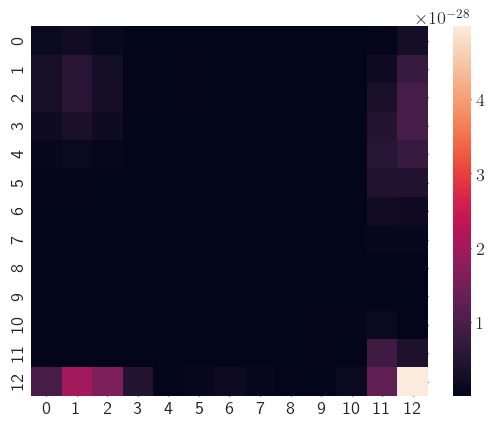

In [35]:
sns.heatmap(dist)

There's no good way of visualizing a 5-dim distribution graphically...